In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import matplotlib.pyplot as plt
import h5py
import numpy as np
import get_xyz
import constants
from pathlib import Path
import hdf5plugin
import streak_finder as sf
import add_geometry_streaks

uint64
952
max number of streaks for frame in file 1
number of streaks: 18


100%|██████████| 18/18 [00:00<00:00, 44858.87it/s]
/tmp/ipykernel_1567290/3634345639.py:64: RuntimeWarning: invalid value encountered in power
  im = frame_im[::-1, ::-1]**0.2


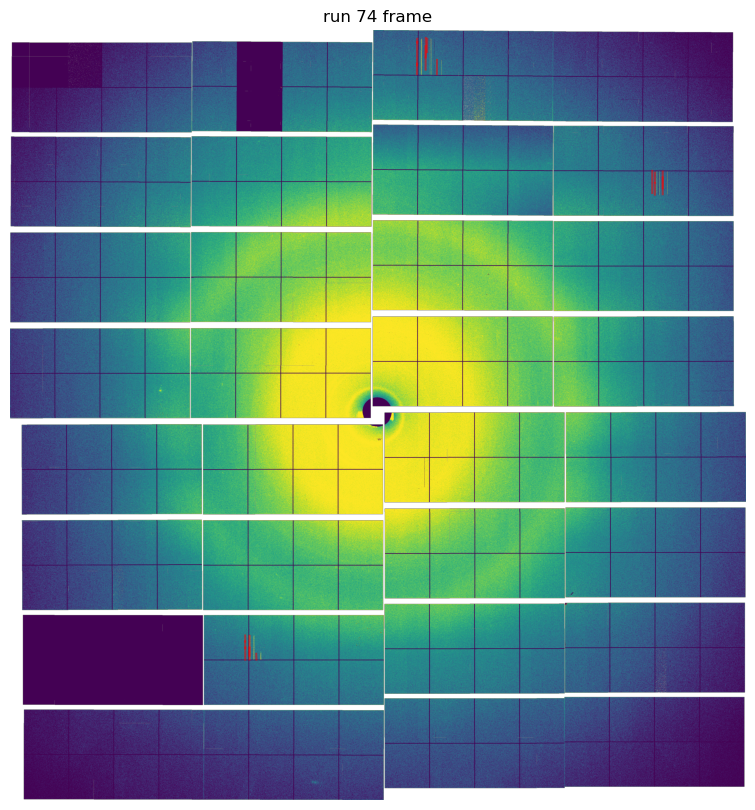

In [37]:
run = 74

# find pattern with a lot of streaks
fnam = Path(constants.beamtime_dir) / f'work/streaks/streaks_run{run:>04}.h5'
if fnam.is_file():
    with h5py.File(fnam) as f:
        streaks = f['fs0_ss0_fs1_ss1_slab'][()]
        pid = np.squeeze(f['pulse_id'][()])
        print(pid.dtype)
        fnams = f['file_name'][()]
        file_index = f['file_index'][()]

    streaks_pid = np.bincount(pid-pid.min())
    j = np.argsort(streaks_pid)[-1]
    pid_max = int(j + pid.min())
    i = np.where(pid_max==pid)[0][0]
    print(i)
    fnam = fnams[i]
    index = file_index[i]
    print(f'max number of streaks for frame in file {streaks_pid[j]}')
else:
    index = 101
    fnam = Path(constants.beamtime_dir) / f'raw/run{run:>04}/data/acq0005.JF07T32V02.h5'

with h5py.File(fnam) as f:
    mask = f['/data/JF07T32V02/meta/pixel_mask'][()]
    frame = f['/data/JF07T32V02/data'][index]
    
frame0 = frame.copy().astype(float)

whitefield_fnam = Path(f'{constants.work}/whitefield/whitefield_run{run:>04}.h5')
assert(whitefield_fnam.is_file())

with h5py.File(whitefield_fnam) as f:
    whitefield = f['whitefield'][()]

whitefield[whitefield == 0] = 1

# scale whitefield
c = np.sum(mask * whitefield * frame) / np.sum(mask * whitefield**2)
frame = np.clip((frame - c * whitefield) / (c * whitefield)**0.5, 0, None)

params = sf.scripts.StreakFinderParameters.read('streak_finder_params.json', 'json')

det_obj = sf.streak_finder.PatternStreakFinder(data=frame, mask=mask, structure=params.streaks.structure.to_structure('2d'),
                                               min_size=params.streaks.min_size, nfa=params.streaks.nfa)

peaks = det_obj.detect_peaks(vmin=params.peaks.vmin, npts=params.peaks.npts, connectivity=params.peaks.structure.to_structure('2d'),
                             num_threads=1)

streaks = det_obj.detect_streaks(peaks, xtol=params.streaks.xtol, vmin=params.streaks.vmin, num_threads=1)

t = streaks[0].to_lines() # (num_streaks, 4) numpy array

print(f'number of streaks: {t.shape[0]}')

if t.shape[0] > 0:
    # apply geometry to frame and peaks
    frame_im, centre = get_xyz.geom_cor(frame0)
    t = add_geometry_streaks.apply_geom_streaks(t)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    im = frame_im[::-1, ::-1]**0.2
    ax.imshow(im, aspect='equal', origin='upper', vmin=np.percentile(im[im>0], 5), vmax=np.percentile(im[im>0], 95))
    
    # plot 1000 streaks
    for s in t:
        ax.plot(-s[1::2]-centre[1], -s[0::2]-centre[0], c='red', alpha=0.5)
    
    ax.set_axis_off()
    ax.set_title(f'run {run} frame')
    plt.show()

np.save('frame_74.npy', frame_im)